# The Graph Data Access

In this notebook, we retrieve live Rai system data from [The Graph](https://thegraph.com/explorer/subgraph/reflexer-labs/rai-mainnet?query=Example%20query) and save it as a CSV for analysis in the [Graph Analysis](TheGraphDataAnalysis.ipynb) notebook.

## Update
The Eth price query is no outdated but we are moving to a posture of taking some information from the Graph and some from Big Query. See [BigQueryRaiData](BigQueryRaiData.ipynb) will be the new source of truth notebook.

## Full Reflexer Labs dashboad query as obtained from Reflexer team
```
{
  internalCoinBalances(where: {accountHandler: "${GEB_STABILITY_FEE_TREASURY}"}) { 
    balance
  }
  accountingEngine(id: "current") { 
    activeDebtAuctions
    activeSurplusAuctions
  }
  collateralType(id: "ETH-A") {
    currentPrice {
      value
    }
    currentMedianizerUpdate {
      value
    }
    debtCeiling
    activeLiquidations
    liquidationsStarted
    totalCollateral
    totalAnnualizedStabilityFee
  }
  systemState(id: "current") { 
    coinUniswapPair {
      reserve0
      reserve1
    }
    currentCoinMedianizerUpdate{
      value
    }
    currentRedemptionRate {
      eightHourlyRate
      annualizedRate
      hourlyRate
      createdAt
    }
    currentRedemptionPrice {
      value
    }
    erc20CoinTotalSupply
    globalDebt
    globalDebtCeiling
    totalActiveSafeCount
    coinAddress
    wethAddress
    systemSurplus
    debtAvailableToSettle
  }
  dailyStats(first: 1000, orderDirection: desc) {
    globalDebt
    timestamp
    redemptionRate {
      twentyFourHourlyRate
    }
  }
  hourlyStats(first: 1000, orderBy: timestamp, orderDirection: desc) {
    globalDebt
    timestamp
    redemptionRate {
      hourlyRate
    }
    redemptionPrice{
      value
    }
    marketPriceUsd
  }
}
```

In [76]:
# import libraries
import pandas as pd
import json
import requests
import matplotlib.pyplot as plt

# Graph
url = 'https://api.thegraph.com/subgraphs/name/reflexer-labs/rai-mainnet'

## Hourly stats

In [77]:
query_header = '''
query {{
    hourlyStats(first: 1000, skip:{}) {{'''

query_tail = '''    
}
}'''

query_body = '''
 timestamp
    blockNumber
    redemptionRate {
      hourlyRate
    }
    redemptionPrice {
      id
      block
      value
      
    }
    marketPriceUsd # price of COIN in USD (uni pool price * ETH median price)
    marketPriceEth # Price of COIN in ETH (uni pool price)
    globalDebt
    erc20CoinTotalSupply
'''


n = 0
hourly = []
while True:
    print(f'request {n+1}')
    query = query_header.format(n*1000) + query_body + query_tail
    r = requests.post(url, json = {'query':query})
    s = json.loads(r.content)['data']['hourlyStats']
    print(f'results {len(s)}')
    hourly.extend(s)
    print(f'total {len(hourly)}')
    n += 1
    if len(s) < 1000:
        break
        
hourlyStats = pd.DataFrame(hourly)

request 1
results 1000
total 1000
request 2
results 243
total 1243


In [78]:
hourlyStats

,blockNumber,erc20CoinTotalSupply,globalDebt,marketPriceEth,marketPriceUsd,redemptionPrice,redemptionRate,timestamp
0,11857308,1988.440432971667032725,1988.577499489843641169436691184972,0.002589462210048543650949087456484599,4.709364363675082915930020079963684,"{'block': '11849022', 'id': '0xe313271188492c4...",{'hourlyRate': '1'},1613338681
1,11860793,2788.440432971667032725,2788.657935201718685876567866781341,0.002481355746535171105569862943787003,4.362594137056344705089877147817243,"{'block': '11860755', 'id': '0x40066774f6fb7d3...",{'hourlyRate': '1'},1613384616
2,11861399,2788.440432971667032725,2788.665345885220347865928144433965,0.002481355746535171105569862943787003,4.419265710853707004204445293455575,"{'block': '11861237', 'id': '0x5c67dbb323db039...",{'hourlyRate': '1'},1613393080
3,11861474,3048.440432971667032725,3048.645954953510904626288422086589,0.001768934955701819449591545208406114,3.194329891923853932595347583210722,"{'block': '11861237', 'id': '0x5c67dbb323db039...",{'hourlyRate': '1'},1613394096
4,11862329,3048.440432971667032725,3048.684410371148757911548668442965,0.001768934955701819449591545208406114,3.215446177235759811208395560891868,"{'block': '11862059', 'id': '0x57ccf842858a814...",{'hourlyRate': '1'},1613405255
...,...,...,...,...,...,...,...,...
1238,12284055,30673555.525391076424305542,30943694.30003156063725555250321439,0.001288650106284142853395988610688639,3.074720861635248222519973858816197,"{'block': '12284026', 'id': '0x03ad7307fbafb3c...",{'hourlyRate': '0.999996542893598514917890311'},1619014669
1239,12284248,30773555.525391076424305542,31044221.16014706034537111774866299,0.001271356898767052871999971857246686,3.082831224017582123141860316455293,"{'block': '12284026', 'id': '0x03ad7307fbafb3c...",{'hourlyRate': '0.999996542893598514917890311'},1619017207
1240,12284611,30823555.525391076424305542,31094272.16317919683557752145251039,0.001253452892039266370807924469255814,3.07162391552898341965594314964545,"{'block': '12284543', 'id': '0x2c8fde5c4420ada...",{'hourlyRate': '0.999996542893598514917890311'},1619022258
1241,12284953,30561398.569238087804097134,30832214.12252610578603505234795974,0.001247543141775904612449046230728387,3.017701987849065032404637943079089,"{'block': '12284816', 'id': '0xeefc27a8b830379...",{'hourlyRate': '0.999991803613185766158739919'},1619026984


In [79]:
hourlyStats.redemptionPrice.values[-1]

{'block': '12284816',
 'id': '0xeefc27a8b8303798e1546e12a472c0f17d426d3d75c3484401081dc56b6fe004-276',
 'value': '3.016533906711977183933196363'}

In [80]:
hourlyStats.redemptionRate.values[-1]

{'hourlyRate': '0.999991803613185766158739919'}

In [81]:
hourlyStats['hourlyredemptionPriceActual'] = hourlyStats.redemptionPrice.apply(lambda x: x['value'])
hourlyStats['hourlyredemptionRateActual'] = hourlyStats.redemptionRate.apply(lambda x: x['hourlyRate'])
del hourlyStats['redemptionRate']
del hourlyStats['redemptionPrice']
hourlyStats['erc20CoinTotalSupply'] = hourlyStats['erc20CoinTotalSupply'].astype(float)
hourlyStats['globalDebt'] = hourlyStats['globalDebt'].astype(float)
hourlyStats['blockNumber'] = hourlyStats['blockNumber'].astype(int)
hourlyStats['hourlymarketPriceEth'] = hourlyStats['marketPriceEth'].astype(float)
del hourlyStats['marketPriceEth']
hourlyStats['hourlymarketPriceUsd'] = hourlyStats['marketPriceUsd'].astype(float)
del hourlyStats['marketPriceUsd']
hourlyStats['hourlyredemptionPriceActual'] = hourlyStats['hourlyredemptionPriceActual'].astype(float)
hourlyStats['hourlyredemptionRateActual'] = hourlyStats['hourlyredemptionRateActual'].astype(float)

In [82]:
hourlyStats.describe()

,blockNumber,erc20CoinTotalSupply,globalDebt,hourlyredemptionPriceActual,hourlyredemptionRateActual,hourlymarketPriceEth,hourlymarketPriceUsd
count,1.243000e+03,1.243000e+03,1.243000e+03,1243.000000,1243.000000,1243.000000,1243.000000
mean,1.206037e+07,3.388400e+07,3.426077e+07,3.051149,0.999969,0.001729,3.144260
std,1.233152e+05,1.102605e+07,1.111630e+07,0.043374,0.000052,0.000302,0.305964
min,1.185731e+07,1.988440e+03,1.988577e+03,3.013686,0.999796,0.001218,2.833647
25%,1.195234e+07,3.239104e+07,3.270842e+07,3.018469,0.999944,0.001500,3.008453
50%,1.204687e+07,3.445235e+07,3.506102e+07,3.030099,0.999985,0.001687,3.076120
75%,1.216812e+07,4.093994e+07,4.124284e+07,3.085764,1.000005,0.001862,3.199380
max,1.228505e+07,4.899876e+07,4.918825e+07,3.140000,1.000051,0.003962,7.138834


## Daily stats - WIP

## System State 

In [83]:
blocknumbers = hourlyStats.blockNumber.values.tolist()

state = []
for i in blocknumbers:
    query = '''
    {
      systemState(block: {number:%s},id:"current") { 
        coinUniswapPair {
          reserve0
          reserve1
        }
        currentCoinMedianizerUpdate{
          value
        }
        currentRedemptionRate {
          eightHourlyRate
          annualizedRate
          hourlyRate
          createdAt
        }
        currentRedemptionPrice {
          value
        }
        erc20CoinTotalSupply
        globalDebt
        globalDebtCeiling
        totalActiveSafeCount
        coinAddress
        wethAddress
        systemSurplus
        debtAvailableToSettle
      }
    }
    ''' % i
    r = requests.post(url, json = {'query':query})
    s = json.loads(r.content)['data']['systemState']
    state.append(s)
        
systemState = pd.DataFrame(state)

systemState.head()
    

,coinAddress,coinUniswapPair,currentCoinMedianizerUpdate,currentRedemptionPrice,currentRedemptionRate,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,wethAddress
0,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '661.764842786150958141', 'reserv...",None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.522357955470745187436691184972,115792089237316195423570985008687.9,0.06853325908830422221834559248594176,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
1,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,2788.440432971667032725,2788.657935201718685876567866781341,115792089237316195423570985008687.9,0.1087511150258265757085590152709335,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
2,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",None,{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,3048.440432971667032725,3048.645954953510904626288422086589,115792089237316195423570985008687.9,0.1161617985274885650688366678947734,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
3,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '801.933726709008306816', 'reserv...",{'value': '0'},{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,3048.440432971667032725,3048.645954953510904626288422086589,115792089237316195423570985008687.9,0.1161617985274885650688366678947734,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2
4,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '801.933726709008306816', 'reserv...",{'value': '0'},{'value': '3.14'},"{'annualizedRate': '1', 'createdAt': '16132260...",0,3048.440432971667032725,3048.696064173575505967822069085347,115792089237316195423570985008687.9,0.1278156009542366213422373102764649,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2


In [84]:
systemState['blockNumber'] = blocknumbers

In [85]:
systemState.coinUniswapPair.values[-1]

{'reserve0': '19857588.503276449364414436',
 'reserve1': '24773.198349470584943216'}

In [86]:
systemState.currentCoinMedianizerUpdate.values[-1]

{'value': '3.039306610555828619'}

In [87]:
systemState.currentRedemptionRate.values[-1]

{'annualizedRate': '0.930716422387766409378098652',
 'createdAt': '1619024273',
 'eightHourlyRate': '0.999934430786516484414864184',
 'hourlyRate': '0.999991803613185766158739919'}

In [88]:
systemState.currentRedemptionPrice.values[-1]

{'value': '3.016533906711977183933196363'}

In [89]:
systemState.columns

Index(['coinAddress', 'coinUniswapPair', 'currentCoinMedianizerUpdate',
       'currentRedemptionPrice', 'currentRedemptionRate',
       'debtAvailableToSettle', 'erc20CoinTotalSupply', 'globalDebt',
       'globalDebtCeiling', 'systemSurplus', 'totalActiveSafeCount',
       'wethAddress', 'blockNumber'],
      dtype='object')

In [90]:
systemState['RedemptionRateAnnualizedRate'] = systemState.currentRedemptionRate.apply(lambda x: x['annualizedRate'])
systemState['RedemptionRateHourlyRate'] = systemState.currentRedemptionRate.apply(lambda x: x['hourlyRate'])
systemState['RedemptionRateEightHourlyRate'] = systemState.currentRedemptionRate.apply(lambda x: x['eightHourlyRate'])
systemState['RedemptionPrice'] = systemState.currentRedemptionPrice.apply(lambda x: x['value'])
systemState['RAIInUniswapV2(RAI/ETH)'] = systemState.coinUniswapPair.apply(lambda x: x['reserve0'])
del systemState['currentRedemptionRate']
del systemState['currentRedemptionPrice']
systemState['RedemptionRateAnnualizedRate'] = systemState['RedemptionRateAnnualizedRate'].astype(float)
systemState['RedemptionRateHourlyRate'] = systemState['RedemptionRateHourlyRate'].astype(float)
systemState['RedemptionRateEightHourlyRate'] = systemState['RedemptionRateEightHourlyRate'].astype(float)
systemState['RedemptionPrice'] = systemState['RedemptionPrice'].astype(float)
systemState['RAIInUniswapV2(RAI/ETH)'] = systemState['RAIInUniswapV2(RAI/ETH)'].astype(float)



In [91]:
systemState.head()

,coinAddress,coinUniswapPair,currentCoinMedianizerUpdate,debtAvailableToSettle,erc20CoinTotalSupply,globalDebt,globalDebtCeiling,systemSurplus,totalActiveSafeCount,wethAddress,blockNumber,RedemptionRateAnnualizedRate,RedemptionRateHourlyRate,RedemptionRateEightHourlyRate,RedemptionPrice,RAIInUniswapV2(RAI/ETH)
0,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '661.764842786150958141', 'reserv...",None,0,2788.440432971667032725,2788.522357955470745187436691184972,115792089237316195423570985008687.9,0.06853325908830422221834559248594176,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11857308,1.0,1.0,1.0,3.14,661.764843
1,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",None,0,2788.440432971667032725,2788.657935201718685876567866781341,115792089237316195423570985008687.9,0.1087511150258265757085590152709335,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11860793,1.0,1.0,1.0,3.14,676.933727
2,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '676.933726709008306816', 'reserv...",None,0,3048.440432971667032725,3048.645954953510904626288422086589,115792089237316195423570985008687.9,0.1161617985274885650688366678947734,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861399,1.0,1.0,1.0,3.14,676.933727
3,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '801.933726709008306816', 'reserv...",{'value': '0'},0,3048.440432971667032725,3048.645954953510904626288422086589,115792089237316195423570985008687.9,0.1161617985274885650688366678947734,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11861474,1.0,1.0,1.0,3.14,801.933727
4,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,"{'reserve0': '801.933726709008306816', 'reserv...",{'value': '0'},0,3048.440432971667032725,3048.696064173575505967822069085347,115792089237316195423570985008687.9,0.1278156009542366213422373102764649,3,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,11862329,1.0,1.0,1.0,3.14,801.933727


## Internal Coin Balances - WIP

## Accounting Engine - WIP

In [94]:
# hourlyStats = hourlyStats.merge(collateralType,how='inner',on='blockNumber')

# # remove duplicate values
# del systemState['erc20CoinTotalSupply']
# del systemState['globalDebt']

# hourlyStats = hourlyStats.merge(systemState,how='inner',on='blockNumber')
# hourlyStats.to_csv('saved_results/RaiLiveGraphData.csv')

## Safes

In [95]:
# get all safe ids
query_header = '''
query {{
    safes(first: 1000, skip:{}) {{'''

query_tail = '''    
}
}'''

query_body = '''
             id
            safeId
            collateralType {
              id
            }
            collateral
            debt
            owner {
              id
            }
            safeHandler # Address of the Safe owner (top level ownership)
            owner {
              id
            } # Optional proxy address (if the owner used a proxy to create the Safe)
            proxy {
              id
            } # Optional proxy address (if the owner used a proxy to create the Safe)
            createdAt # Timestamp of the block at which this Safe was opened [seconds]
            createdAtBlock # Block number at which this Safe was opened
            createdAtTransaction # Hash of the transaction that opened the Safe
'''


n = 0
safes = []
while True:
    print(f'request {n+1}')
    query = query_header.format(n*1000) + query_body + query_tail
    r = requests.post(url, json = {'query':query})
    s = json.loads(r.content)['data']['safes']
    print(f'results {len(s)}')
    safes.extend(s)
    print(f'total {len(safes)}')
    n += 1
    if len(s) < 1000:
        break
        
safes_df = pd.DataFrame(safes)

request 1
results 1000
total 1000
request 2
results 919
total 1919


In [96]:
safes_df

,collateral,collateralType,createdAt,createdAtBlock,createdAtTransaction,debt,id,owner,proxy,safeHandler,safeId
0,0,{'id': 'ETH-A'},1614276509,11927837,0xb513acdb3d62826757187dfc6e8650f6b4a5aafc082a...,0,0x004f347f017acd2fa14fa7fe7414216cc00f8ac1-ETH-A,{'id': '0xd912c21ca7c215594ce55de8080a8cd6b7a0...,{'id': '0xc2c59f75836656dd23e3eb89e55fa74bb5ab...,0x004f347f017acd2fa14fa7fe7414216cc00f8ac1,1133
1,0,{'id': 'ETH-A'},1616861323,12122070,0xba8455900bca1742918ef6355e6283dc3ab518896be3...,0,0x0070916a66f728dc0457dfacb96c89d313955dd9-ETH-A,{'id': '0xd30391e21741c54c32987bcfca3d880e6d26...,{'id': '0x40cd68d8c3795fb846c58c4ff8ba0e40b8f9...,0x0070916a66f728dc0457dfacb96c89d313955dd9,1753
2,0,{'id': 'ETH-A'},1613944193,11902865,0xc754de50823a71a38dd2cb65576c5669a34504d2f5e9...,0,0x0082d2052d608c46b74387dd548e99c615ef1e4c-ETH-A,{'id': '0xf33e5fd85a5905380c5f1b0ae444bb995287...,{'id': '0x5f7fb93454d64f386b1e559aa694bd85a003...,0x0082d2052d608c46b74387dd548e99c615ef1e4c,878
3,4,{'id': 'ETH-A'},1614937613,11977561,0xf7592173317c4b065a2727df0f9b8dd37a64403104cb...,799.142093799608254196,0x0092eb3f04319f7ef269f71f3dda2eda5efe438b-ETH-A,{'id': '0x0b5a3054e7d7c25c23ee8b7fd7cba3d2660b...,{'id': '0x7fbfe4b7ee75c2f6d21378b9c0e1b26be851...,0x0092eb3f04319f7ef269f71f3dda2eda5efe438b,1352
4,3,{'id': 'ETH-A'},1615258265,12001739,0x2da501ec34916c8ffb6286f9d4671c12e3d3b3f715c0...,798.981203283309975931,0x00b9b919d6bc0b70fd4566d84f77de1f42b4dbde-ETH-A,{'id': '0xdd99fa1e4312146cf5029be7bdeb18c912f4...,{'id': '0x83bc84ef618c36b3642416f67f344406c9b1...,0x00b9b919d6bc0b70fd4566d84f77de1f42b4dbde,1491
...,...,...,...,...,...,...,...,...,...,...,...
1914,40,{'id': 'ETH-A'},1615299608,12004773,0xa3222b673cda66e504e4eede4268e2796fb9b4e40275...,7490.254325207458258746,0xff764ccaf7e529aee2ce925fcf7ea3f2434f59ee-ETH-A,{'id': '0x1a68dbe7bb1160bb390d06d68f3e41516cc8...,{'id': '0x57823f492bb5bbdc1fec37bf5f3c27607e0a...,0xff764ccaf7e529aee2ce925fcf7ea3f2434f59ee,1516
1915,0,{'id': 'ETH-A'},1613976307,11905298,0xe33de60560a7380a54945a343120aee9db2c205dd3f3...,0,0xff7fedfd85f861a61d95de9e3c83eaf4e06de5cc-ETH-A,{'id': '0x4d30a3cd1c738cf64101e699bb19f4f2d96d...,{'id': '0x5525ce6398fb2da367570ab9a782ab6cf360...,0xff7fedfd85f861a61d95de9e3c83eaf4e06de5cc,937
1916,128,{'id': 'ETH-A'},1613665650,11881902,0x705ce14acf74bc66c3da7632d5a8c63d0ca3a442aaac...,51996.571735784516277477,0xff9b5fd13b60f1e7111bb864c7b561aaadfead2a-ETH-A,{'id': '0x6ddbfa02a80ab01d0b31b6cafe18ad758f7e...,{'id': '0x7d4560797f78ae0eca881648d171afb4ec17...,0xff9b5fd13b60f1e7111bb864c7b561aaadfead2a,295
1917,9,{'id': 'ETH-A'},1613649838,11880726,0xfb1866c982e38d9dfd6caee522f9d46bc957c4c4f8f5...,1999.471437164020345288,0xffdb87ebd534f67da7aefa8ad05aeb6de27b241d-ETH-A,{'id': '0xee779e4b3e7b11454ed80cfe12cf48ee3ff4...,{'id': '0x4ea2699ba7f0d81be2f033c4f80113a6d03a...,0xffdb87ebd534f67da7aefa8ad05aeb6de27b241d,271


In [97]:
safes_df.query('safeId == "45"')

,collateral,collateralType,createdAt,createdAtBlock,createdAtTransaction,debt,id,owner,proxy,safeHandler,safeId
1910,30,{'id': 'ETH-A'},1613572537,11874913,0x91cd5484ea440c9dbad7bbcac97733cc56852e989f17...,5197.607015594878378064,0xff317a6ed7f48890e0e368f7d3353e1bb856b58b-ETH-A,{'id': '0xdf290293c4a4d6ebe38fd7085d7721041f92...,{'id': '0x95dae23d9106dc7b337084109d440c479ba8...,0xff317a6ed7f48890e0e368f7d3353e1bb856b58b,45


In [100]:
# {
#   modifySAFECollateralization(id:"0xff317a6ed7f48890e0e368f7d3353e1bb856b58b-ETH-A") {
#     id
#     safe {
#       id
#     }
#     safeHandler
#     collateralType {
#       id
#     }
#     deltaCollateral
#     deltaDebt
#     accumulatedRate
#     createdAt
#     createdAt
#     createdAtTransaction
#   }
# }



In [101]:
safes_df.debt = safes_df.debt.apply(float)
safes_df.collateral = safes_df.collateral.apply(float)
safes_df['debt_ratio'] = safes_df.debt/safes_df.collateral 

<AxesSubplot:>

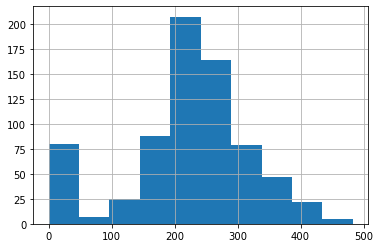

In [102]:
safes_df.debt_ratio.hist()

<AxesSubplot:>

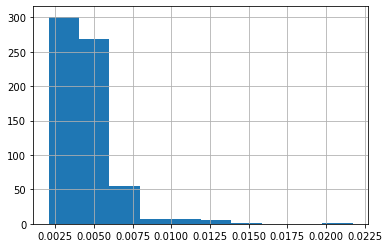

In [103]:
safes_df[safes_df.debt_ratio>0].debt_ratio.apply(lambda x :1/x).hist()

## Conclusion

Using The Graph, a lot of data about the Rai system can be obtained for analyzing the health of the system. With some data manipulation, these data streams could be intergrated into the Rai cadCAD model to turn it into a true decision support system. 

### Update
The Eth price query is no outdated but we are moving to a posture of taking some information from the Graph and some from Big Query. See [BigQueryRaiData](BigQueryRaiData.ipynb) will be the new source of truth notebook.